In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import wandb
import hydra
import omegaconf
from omegaconf import DictConfig, OmegaConf
import os
import numpy as np
import sklearn
from sklearn.datasets import make_moons
from sfm.distributions import get_source_distribution



In [2]:
def plot_dataset(data, name="data", norm=True):
    data = data.cpu().numpy()
    print(name)
    print(data.shape)
    plt.figure(figsize=(4.8, 4.8), dpi=150)
    if data.shape[1] == 2:
        if norm:
            data[:, 0] = (data[:, 0] - data[:, 0].min()) / (data[:, 0].max() - data[:, 0].min())
            data[:, 1] = (data[:, 1] - data[:, 1].min()) / (data[:, 1].max() - data[:, 1].min())
        plt.hist2d(*data.T, bins=64)
    elif data.shape[1] == 3:
        ax = plt.gca()
        if norm:
            data[:, 0] = (data[:, 0] - data[:, 0].min()) / (data[:, 0].max() - data[:, 0].min())
            data[:, 1] = (data[:, 1] - data[:, 1].min()) / (data[:, 1].max() - data[:, 1].min())
            data[:, 2] = (data[:, 2] - data[:, 2].min()) / (data[:, 2].max() - data[:, 2].min())
        ax.scatter(*data.T)
    plt.show()


gaussians
(70000, 2)


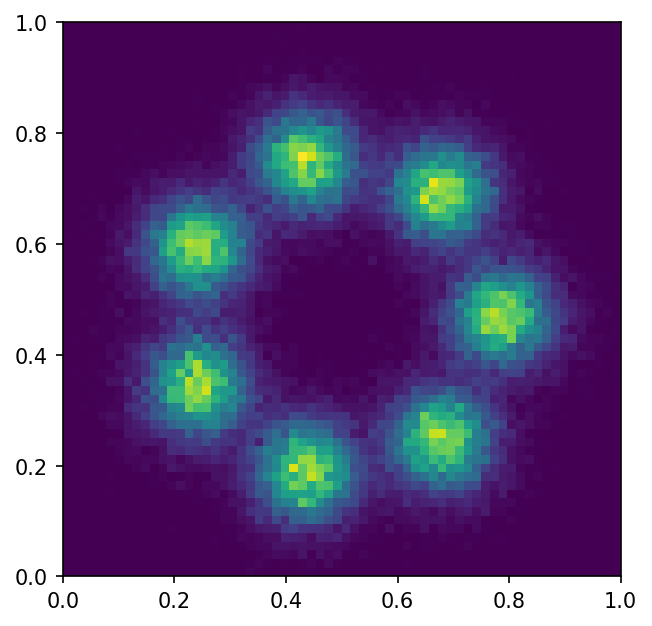

gaussians_spiral
(70000, 2)


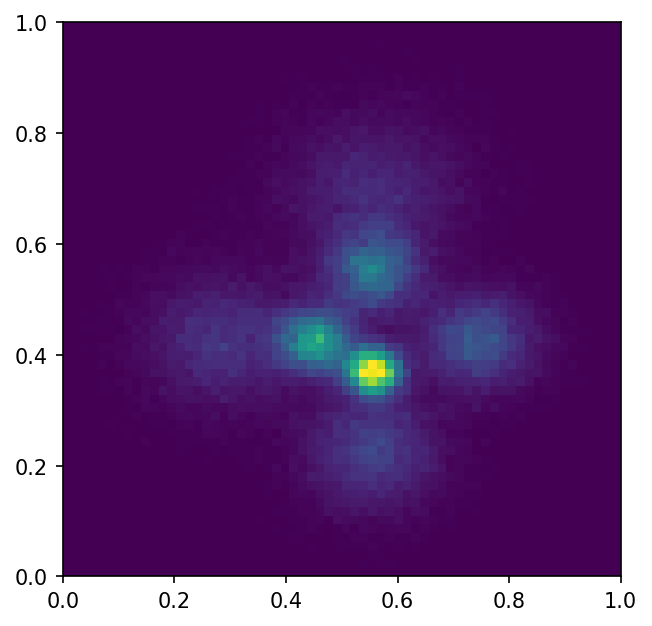

moons
(10000, 2)


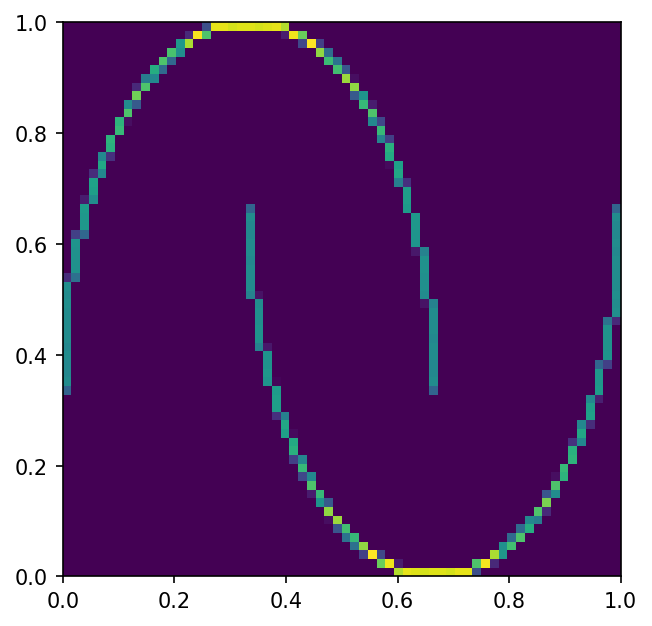

spirals
(20000, 2)


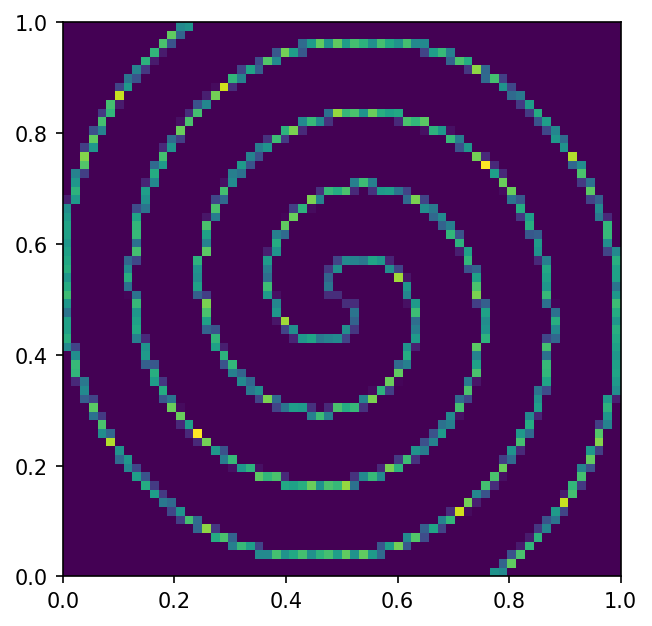

concentric_spheres
(10000, 3)


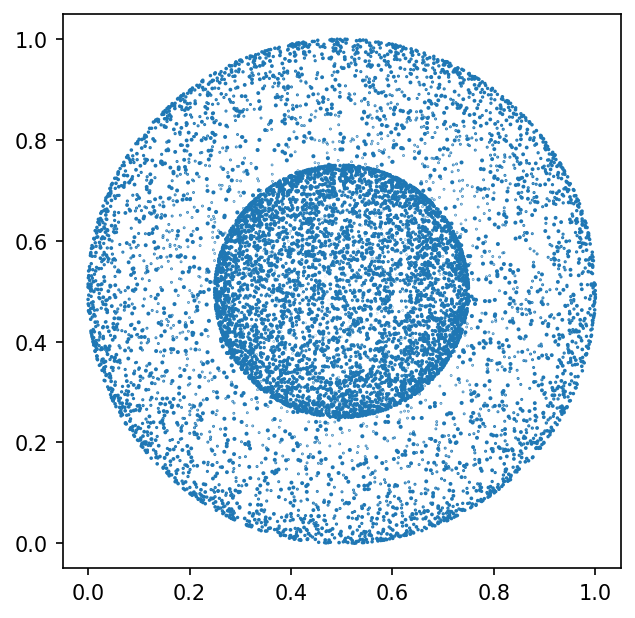

diffeqml
(10000, 2)


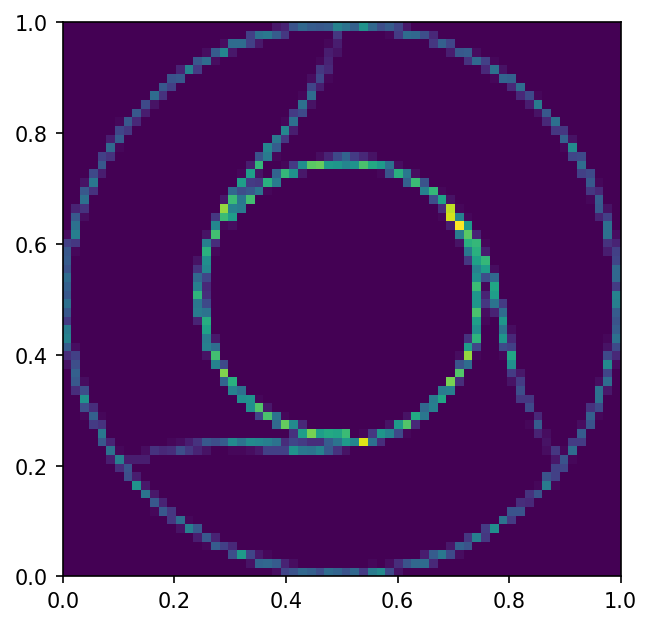

In [3]:
from torchdyn.datasets import generate_moons, generate_spirals, generate_concentric_spheres, generate_diffeqml, generate_gaussians_spiral, generate_gaussians

n_samples = 10000
data, _ = generate_gaussians(n_samples)
plot_dataset(data, "gaussians")

data, _ = generate_gaussians_spiral(n_samples)
plot_dataset(data, "gaussians_spiral")

data, _ = generate_moons(n_samples)
plot_dataset(data, "moons")

data, _ = generate_spirals(n_samples)
plot_dataset(data, "spirals")

data, _ = generate_concentric_spheres(n_samples)
plot_dataset(data, "concentric_spheres")

data, _ = generate_diffeqml(n_samples)
plot_dataset(data, "diffeqml")


gaussians
(70000, 2)


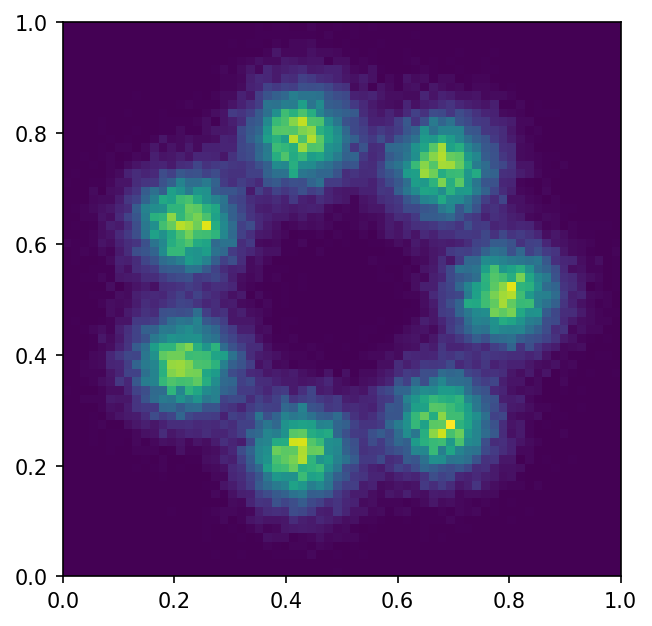

8gaussians
(10000, 2)


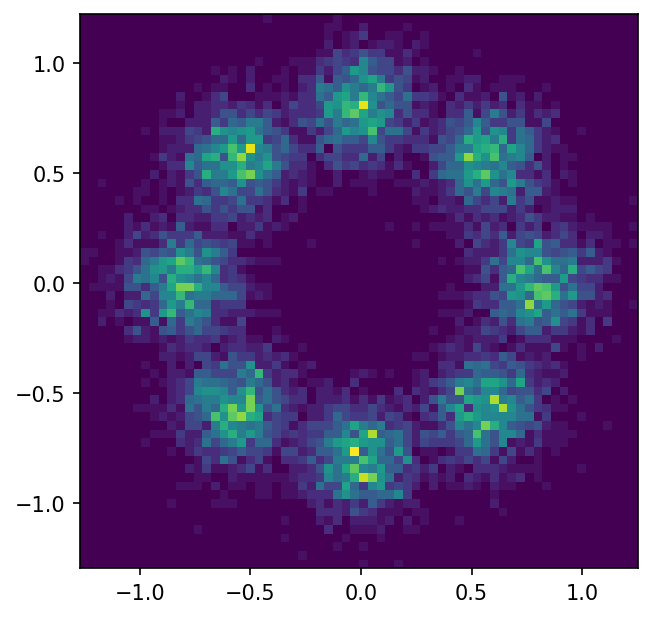

In [4]:
from sfm.datasets import sample_dataset

n_samples = 10000
# 8gaussians
data, _ = sample_dataset("gaussians", n_samples)
plot_dataset(data, "gaussians")

from sfm.datasets import print_normed_func
from sfm.distributions import EightGaussiansDistribution

dist = EightGaussiansDistribution()
data = dist.sample(n_samples)
plot_dataset(data, "8gaussians", norm=False)



shape torch.Size([10000, 2])


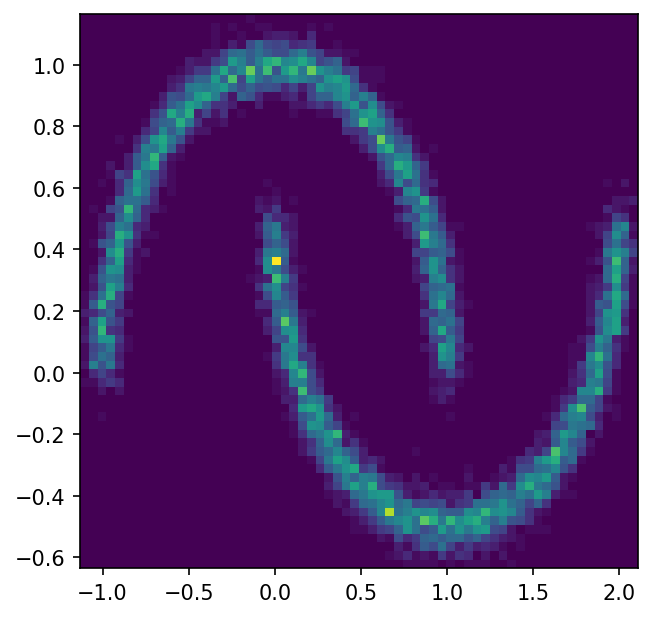

In [5]:
n_samples = 10000
datanoise = 0.05
data, _ = make_moons(n_samples, noise=datanoise)
data = torch.from_numpy(data).float()

# plt.scatter(data[:, 0], data[:, 1])
# plt.show()


print("shape", data.shape)

if isinstance(data, torch.Tensor):
    data = data.cpu().numpy()
plt.figure(figsize=(4.8, 4.8), dpi=150)
plt.hist2d(*data.T, bins=64)
plt.show()

In [6]:
def plot_dist(n_samples=1000, **kwargs):
    dist = get_source_distribution(**kwargs)
    samples = dist.sample(n_samples)

    # plt.scatter(samples[:, 0], samples[:, 1])
    # plt.show()

    if isinstance(samples, torch.Tensor):
        samples = samples.cpu().numpy()
    plt.figure(figsize=(4.8, 4.8), dpi=150)
    plt.hist2d(*samples.T, bins=64)
    plt.show()

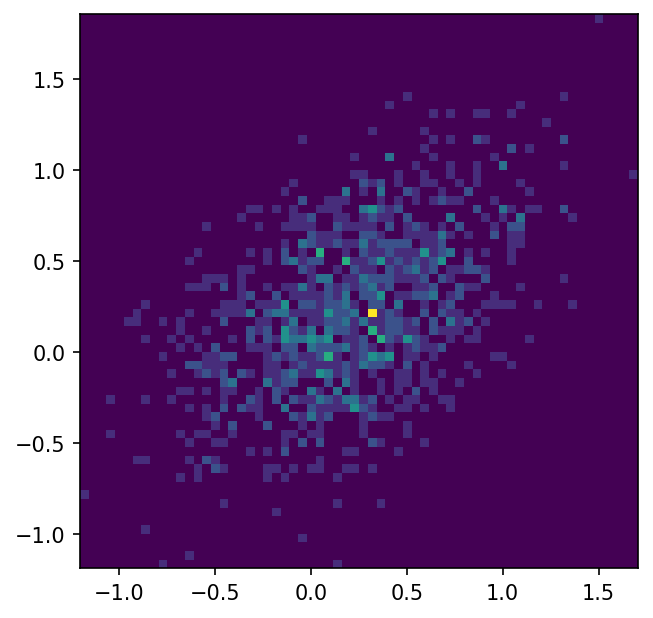

In [7]:
plot_dist(
    n_samples=1000,
    **{"trgt": "gaussian", "mu": torch.tensor([0.2, 0.2]), "Sigma": torch.tensor([[0.2, 0.1], [0.1, 0.2]])},
)


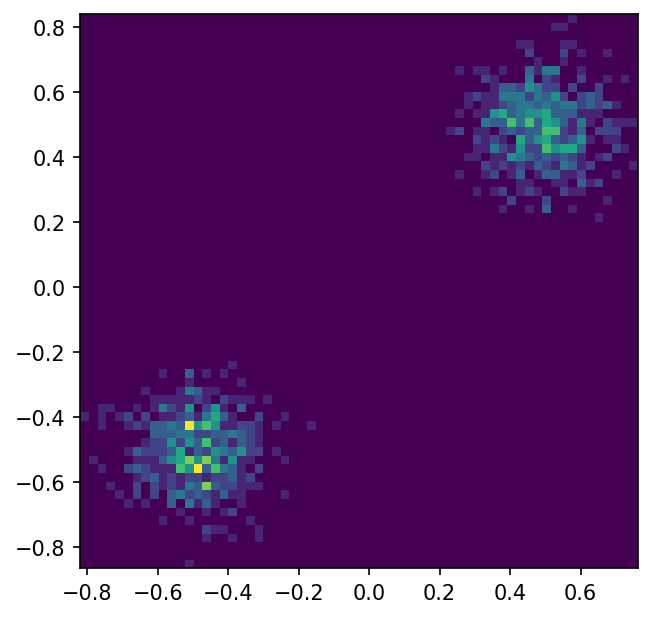

In [8]:
plot_dist(
    n_samples=1000,
    **{
        "trgt": "mog",
        "mus": torch.tensor([[-0.5, -0.5], [0.5, 0.5]]),
        "sigmas": torch.tensor([[0.1, 0.1], [0.1, 0.1]]),
        "pis": torch.tensor([0.5, 0.5]),
    },
)

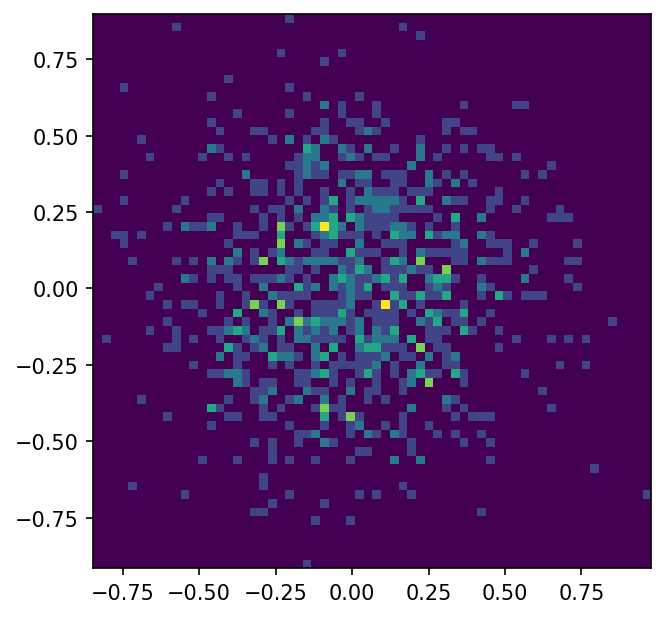

In [9]:
plot_dist(
    n_samples=1000,
    **{"trgt": "normal", "mean": 0, "std": 0.3},
)


/ssd/gen/fm/src/sfm/config/source ['weibull.yaml', 'cauchy.yaml', 'kumaraswamy.yaml', 'pareto.yaml', 'studentt.yaml', 'relaxedbernoulli.yaml', 'lognormal.yaml', 'isotropic.yaml', 'halfnormal.yaml', 'chi2.yaml', 'uniform.yaml', 'dirichlet.yaml', 'halfcauchy.yaml', 'inversegamma.yaml', 'beta.yaml', '8gaussians.yaml', 'lowrank.yaml', 'laplace.yaml', 'vonmises.yaml', 'multivariate.yaml', 'exponential.yaml', 'gaussian.yaml', 'gumbel.yaml', 'fisher.yaml', 'mog.yaml', 'normal.yaml', 'gamma.yaml', 'diagonal.yaml']


/tmp/ipykernel_930532/4135027892.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(4.8, 4.8), dpi=150)


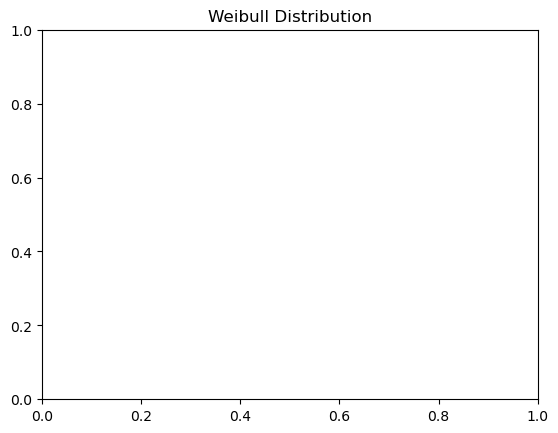

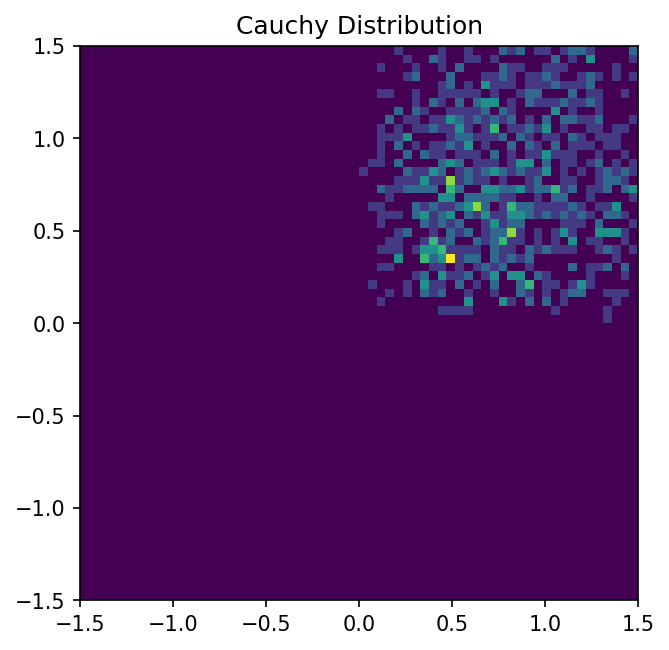

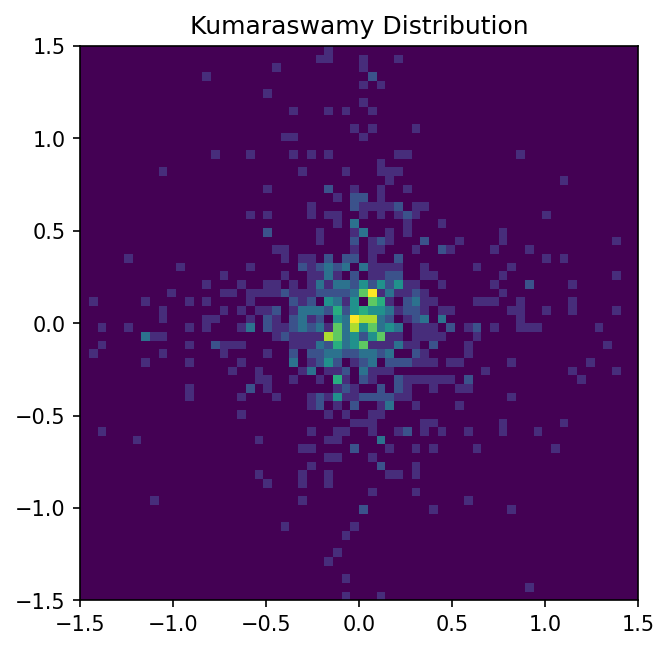

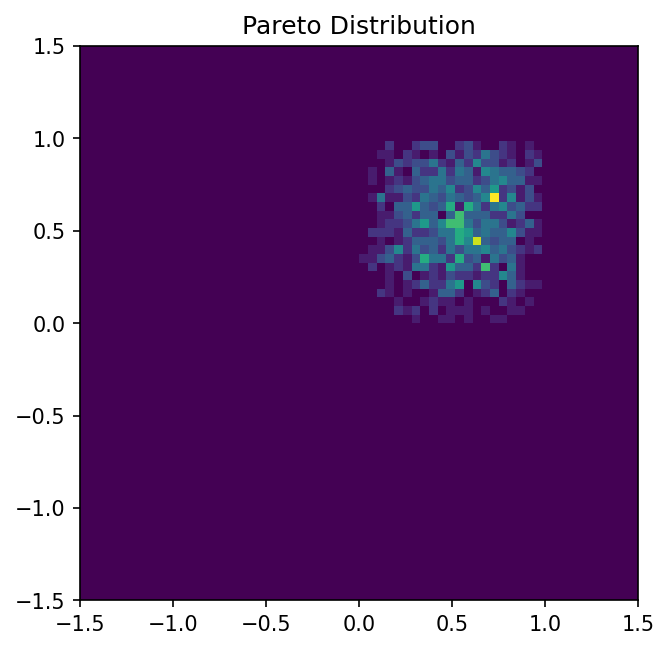

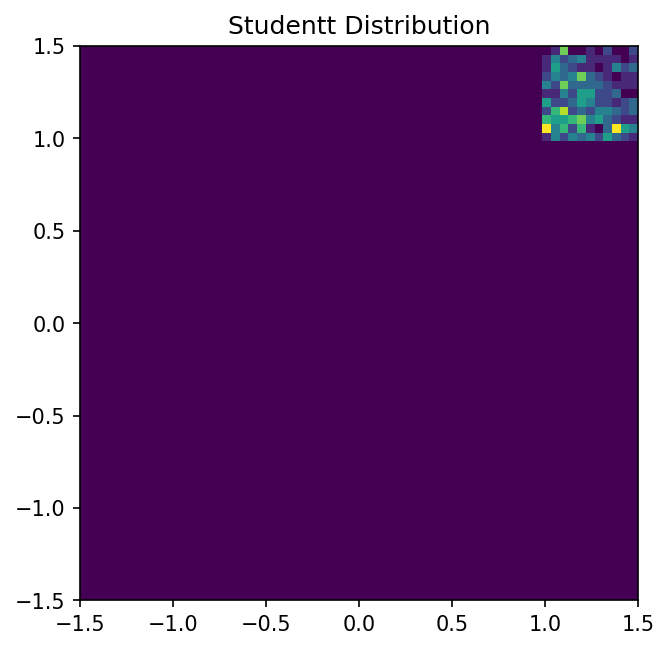

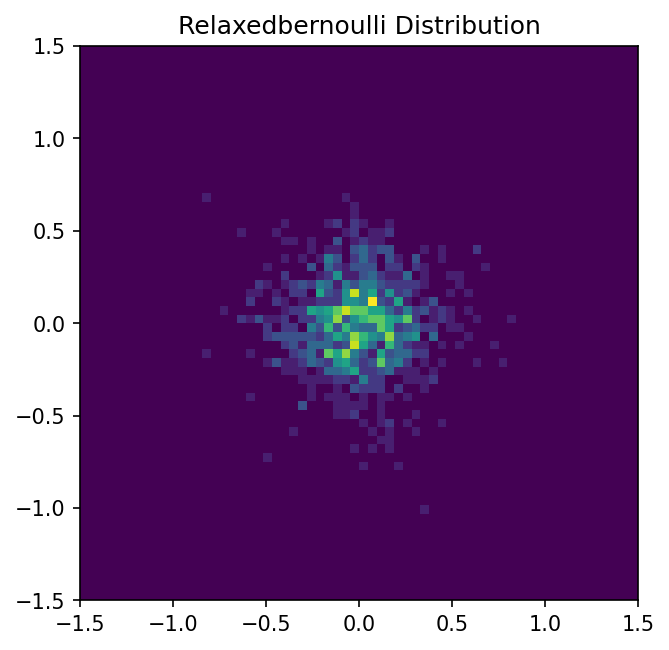

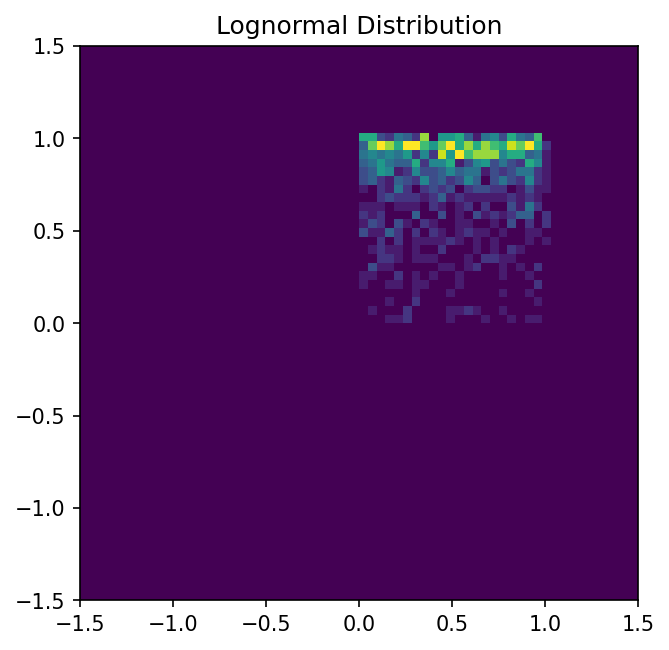

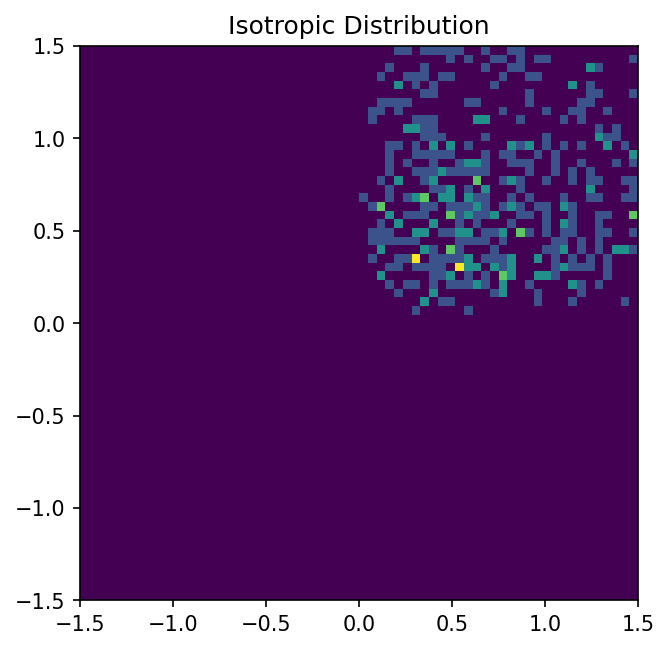

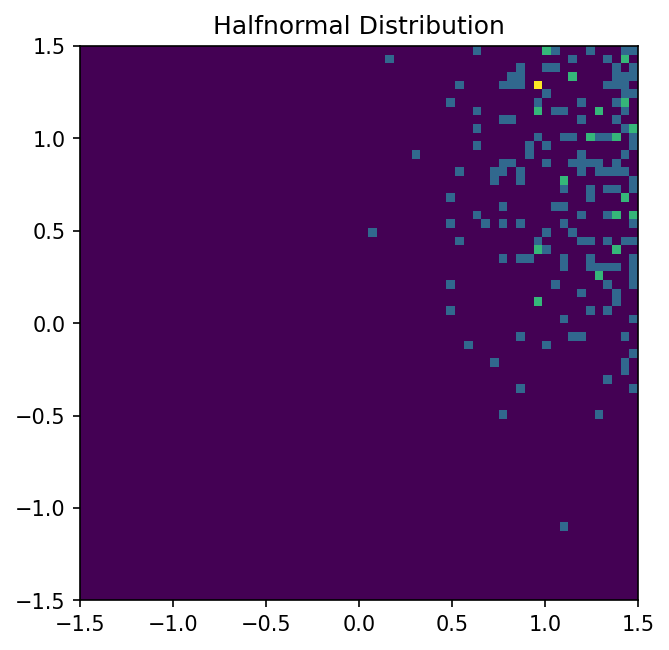

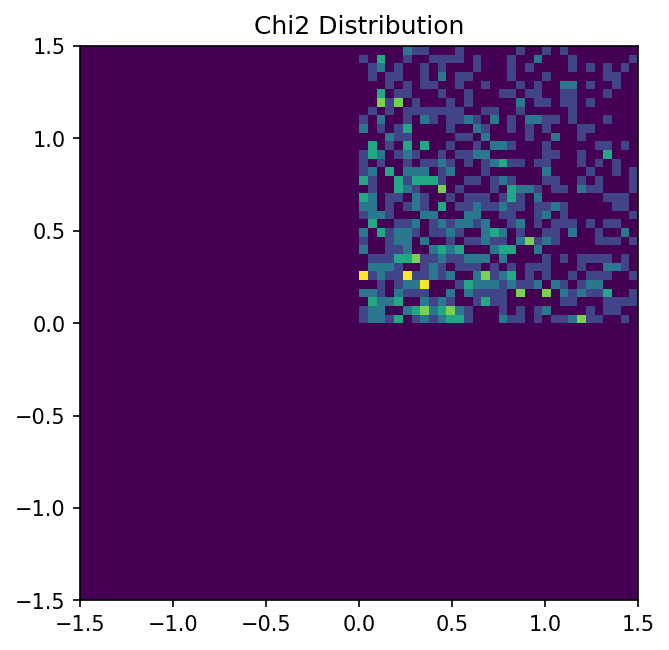

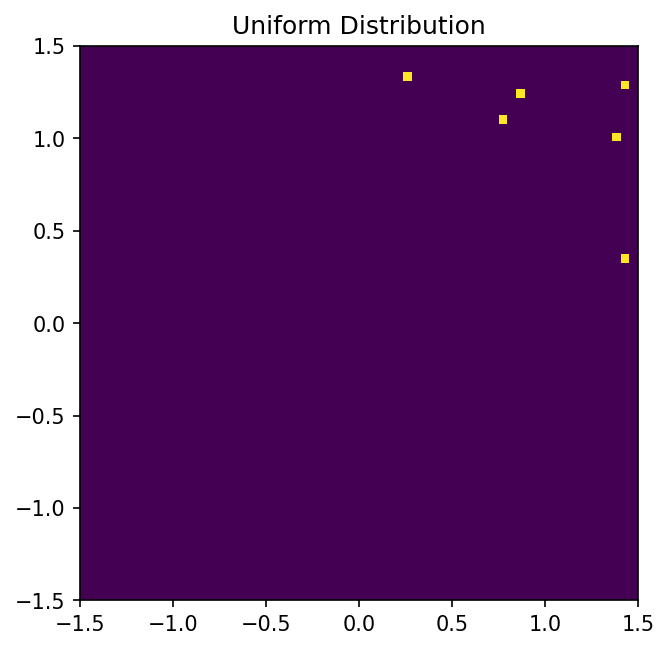

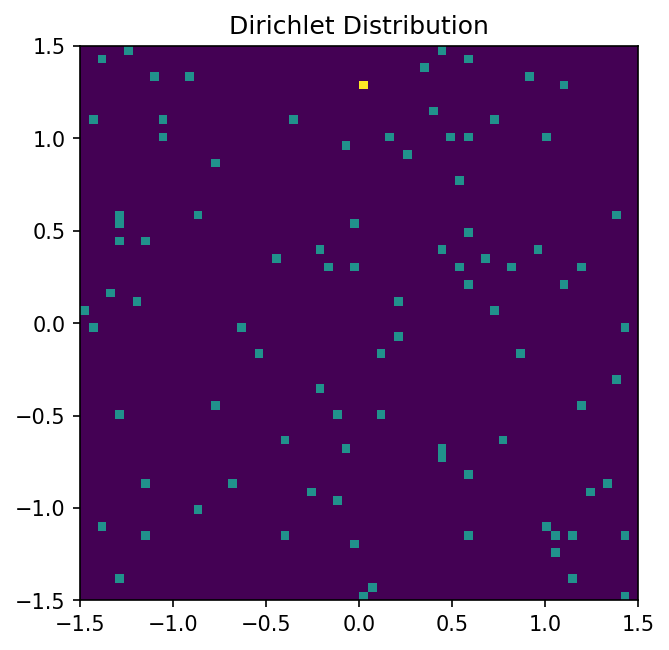

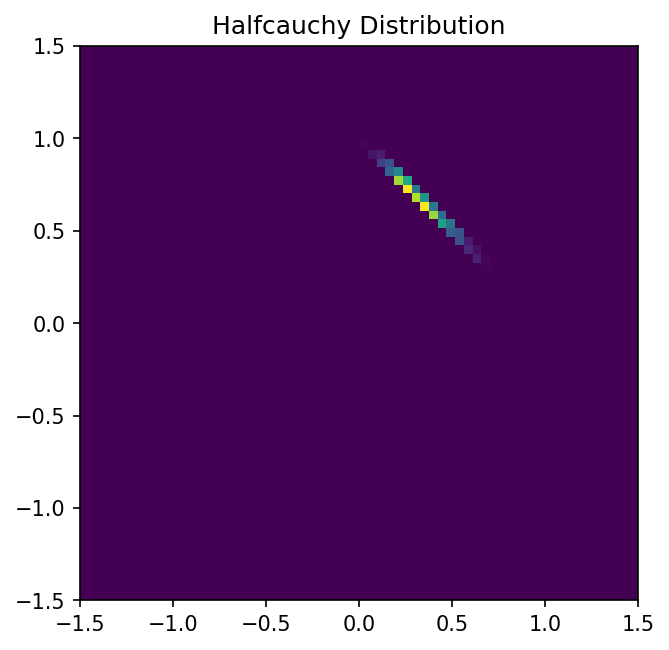

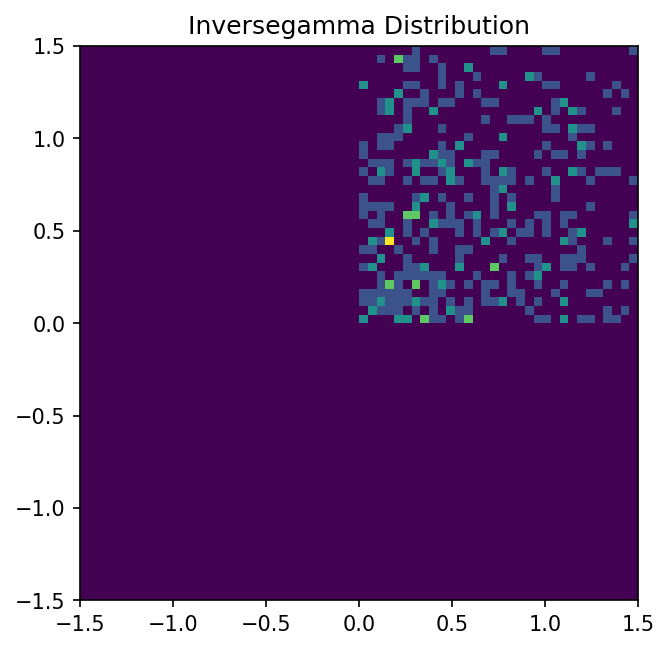

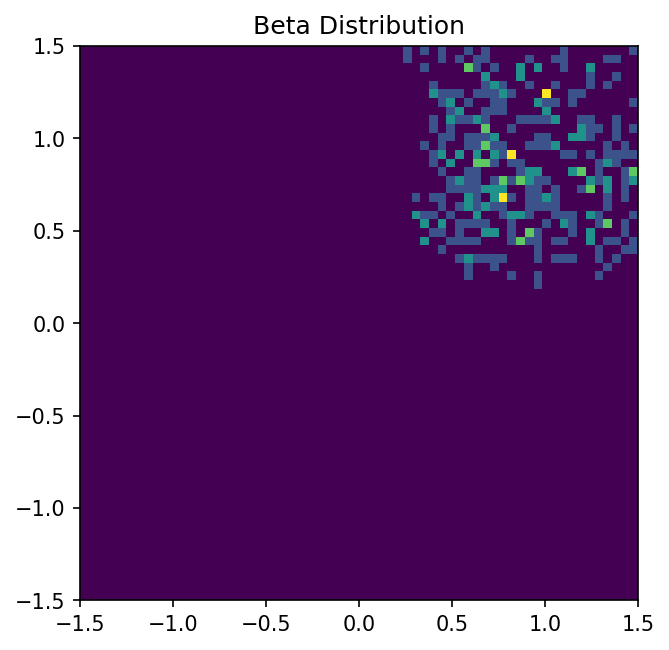

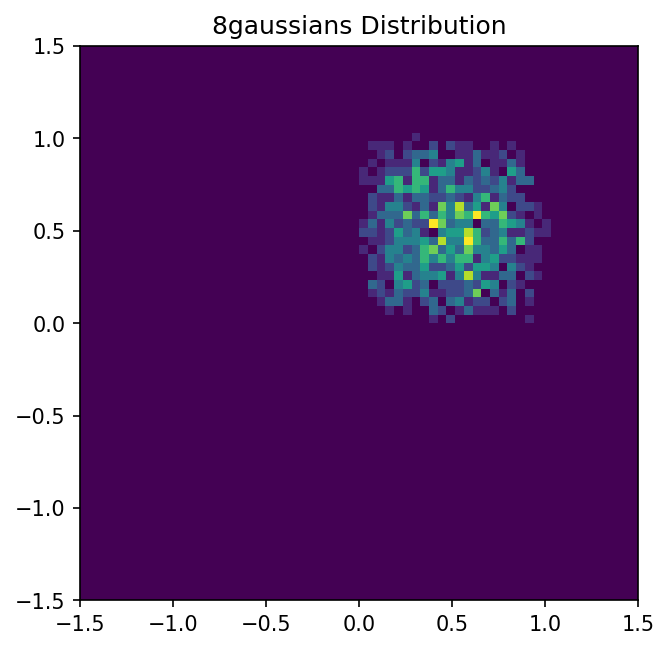

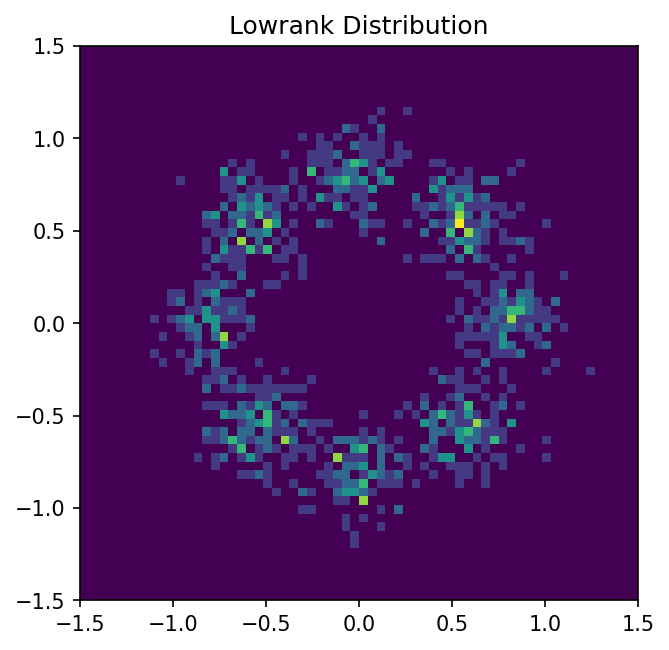

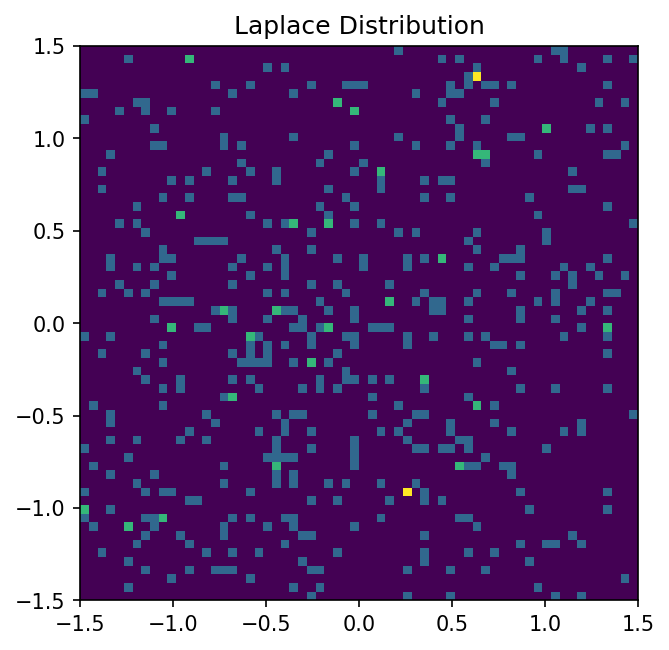

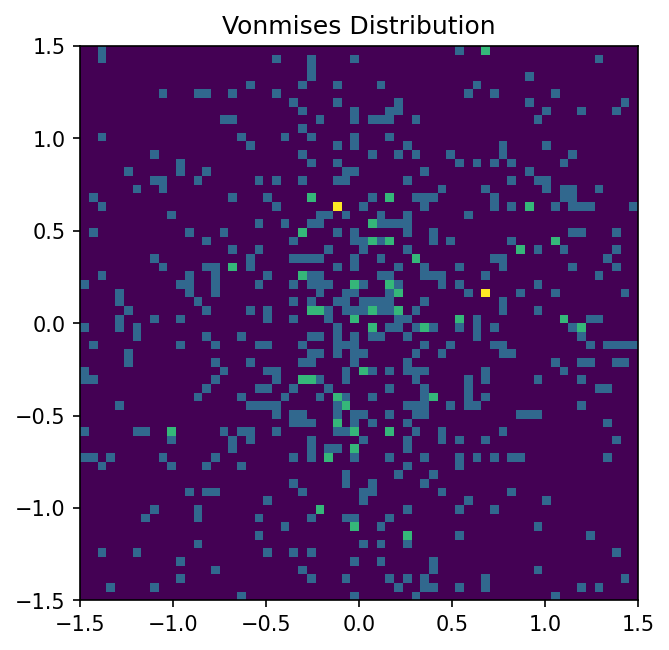

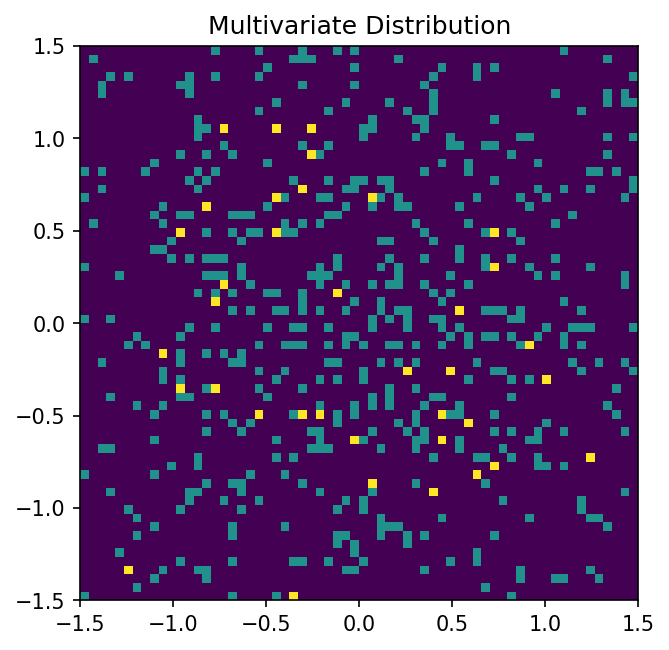

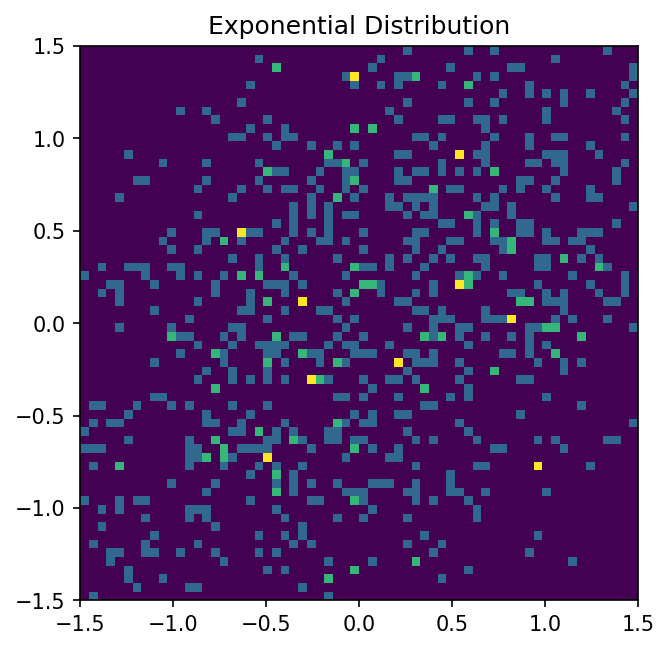

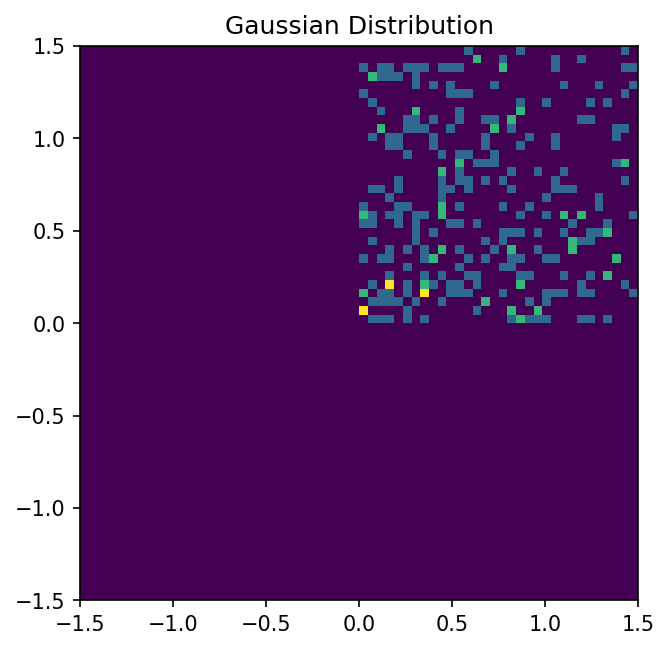

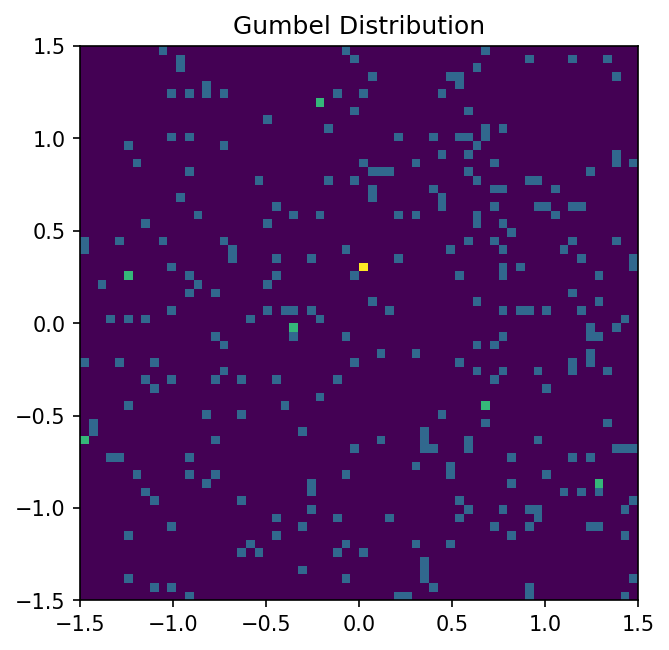

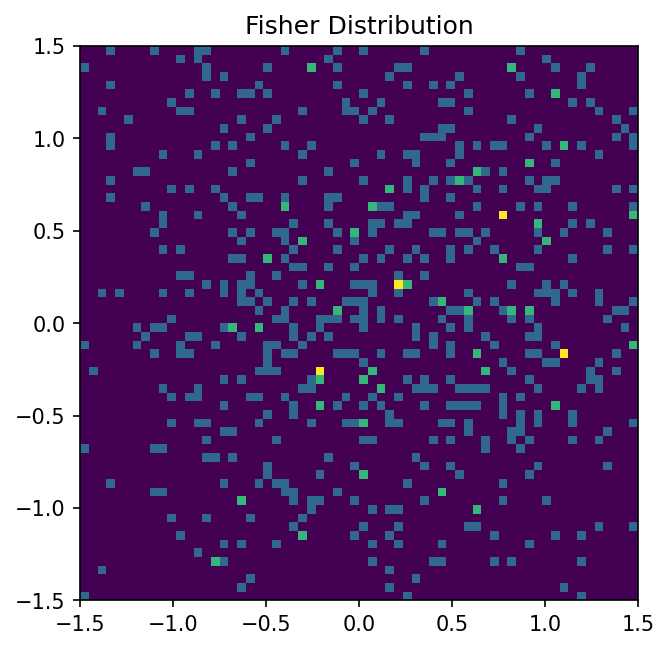

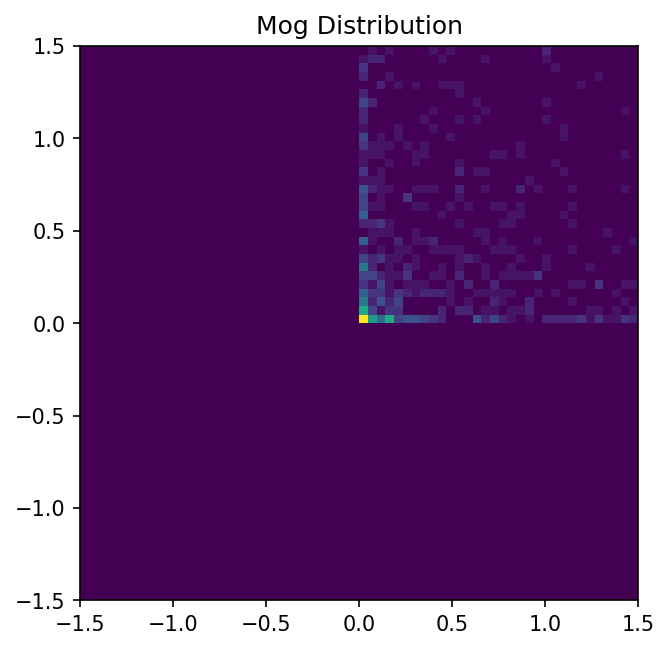

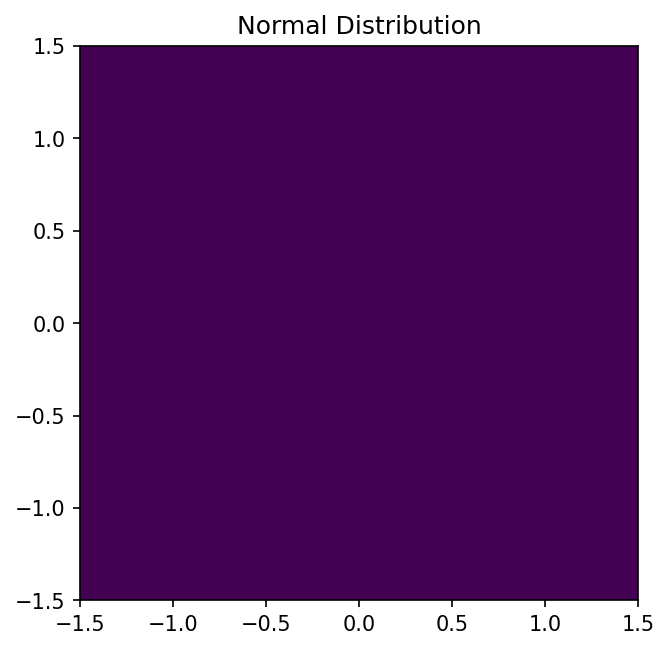

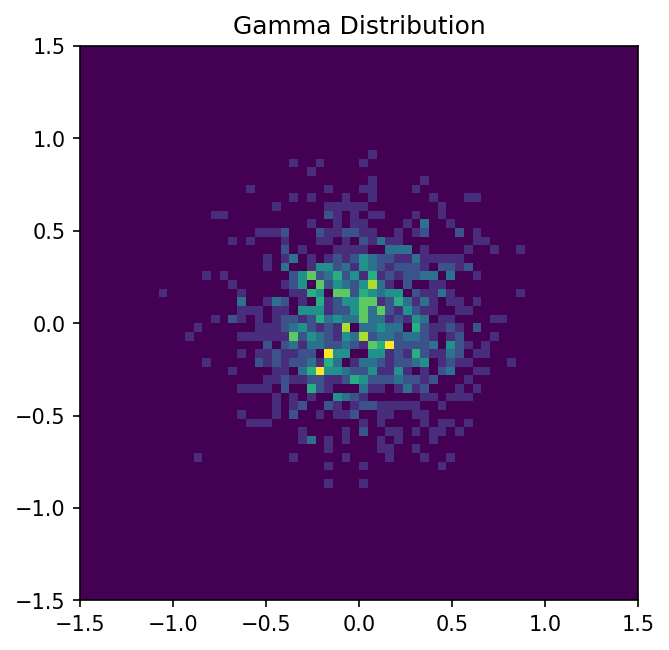

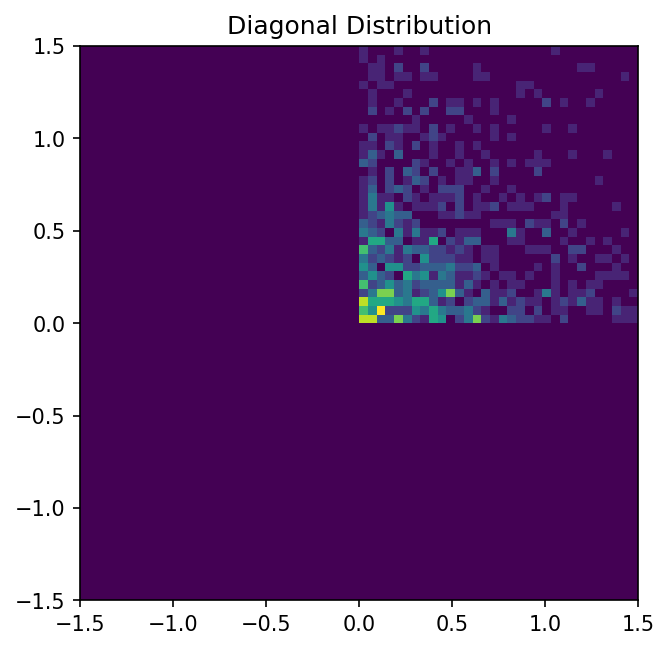

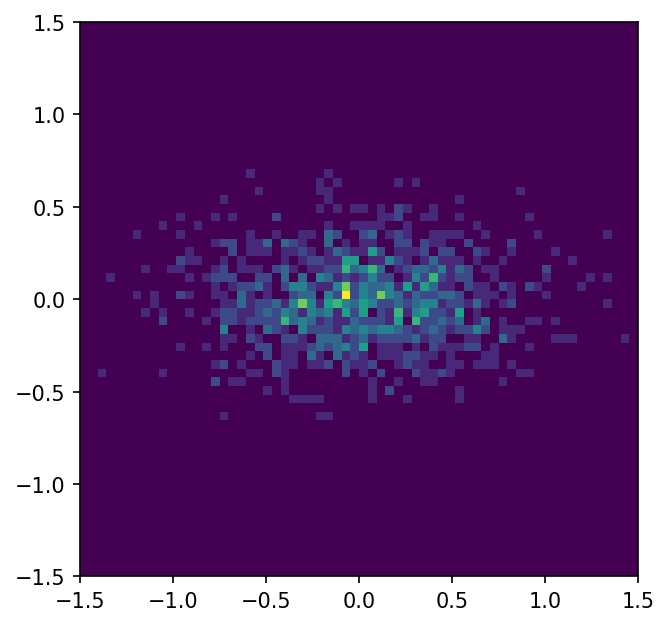

In [10]:
# currentfile = os.path.abspath(__file__)
currentfile = os.path.abspath("")
currentdir = os.path.dirname(currentfile)
source_dir = os.path.abspath(f"{currentdir}/src/sfm/config/source/")
print(source_dir, os.listdir(source_dir))

distributions = {}
for fname in os.listdir(source_dir):
    with open(f"{source_dir}/{fname}", "r") as f:
        cfg = omegaconf.OmegaConf.load(f)
        name = os.path.splitext(fname)[0].replace(".yaml", "")
        distributions[name] = cfg["source"]

n_samples = 1000

# Plot each distribution
for name, params in distributions.items():
    plt.title(f"{name.capitalize()} Distribution")

    dist = get_source_distribution(**params)
    samples = dist.sample(n_samples)
    if isinstance(samples, torch.Tensor):
        samples = samples.cpu().numpy()
    assert samples.shape == (n_samples, 2), f"Samples have wrong shape {samples.shape}"

    fig = plt.figure(figsize=(4.8, 4.8), dpi=150)
    ax = plt.gca()
    ax.hist2d(*samples.T, bins=64, range=np.array([(-1.5, 1.5), (-1.5, 1.5)]))
    # ax.set_xlim(-1.5, 1.5)
    # ax.set_ylim(-1.5, 1.5)
    # plt.show()
    # plt.close()

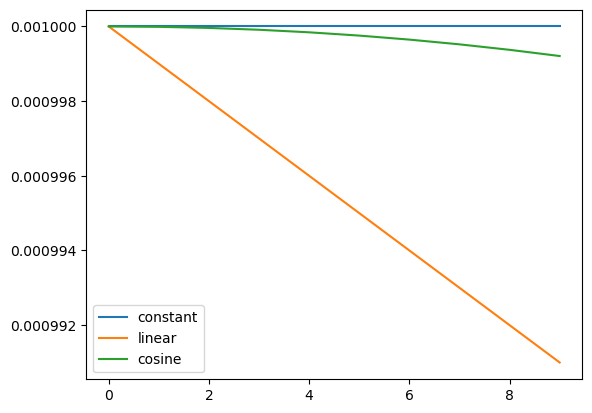

In [11]:
# plot learning rate schedule
from sfm.trainer import get_lr_schedule
from sfm.flowmodel import ContNormFlow
from sfm.networks import MLPSepTimeEmb

model = MLPSepTimeEmb()
model = ContNormFlow(model, source={"trgt": "gaussian", "mu": torch.tensor([0.0, 0.0]), "Sigma": torch.tensor([[1.0, 0.5], [0.5, 1.0]])})

schedules = ["constant", "linear", "cosine"]
for schedule in schedules:
    cfg = DictConfig({
        "optim": {"lr": 1e-3, "lr_min": 1e-5},
        "n_trainsteps": 1000,
        "lr_schedule": schedule,
    })
    optimizer = torch.optim.Adam(model.parameters(), lr=cfg["optim"]["lr"])
    lr_schedule = get_lr_schedule(optimizer, cfg)

    lrs = []
    for i in range(10):
        lrs.append(optimizer.param_groups[0]["lr"])
        optimizer.step()
        lr_schedule.step()

    plt.plot(lrs, label=schedule)

plt.legend()
plt.show()


In [12]:
c1 = torch.tensor(0.5)
c2 = torch.tensor(0.5)
x = torch.tensor([0.0, 1.0])

# works: all on cpu
beta = torch.distributions.Beta(c1, c2)
beta.log_prob(x)

# fails: x on cuda, c1 and c2 on cpu
# x = x.to("cuda")
# beta.log_prob(x)

# works
beta = torch.distributions.Beta(c1.to("cuda"), c2.to("cuda"))
x = x.to("cuda")
beta.log_prob(x)

# works
x = x.to("cuda")
beta._dirichlet.concentration = beta._dirichlet.concentration.to("cuda")
beta.log_prob(x)


tensor([inf, inf], device='cuda:0')